In [631]:
# TODO:
# [] plot for energy over time
# [] plot for mass over time
# [] apply the upwind scheme

In [637]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mesh import create_2d_circle, create_toy_mesh
from discretization import create_discretization_element, create_discretization_mesh
from solver_bvp import BVP_Poisson_solver, get_n_element_operators
from scipy.integrate import solve_ivp
import scipy as sp

from mesh import Mesh
from discretization import DiscretizationElement, DiscretizationMesh
import numpy.typing as npt

import warnings
warnings.filterwarnings('ignore')

## Poisson Problem

In [638]:
### test 1 - chat
def u_exact(x, y): return np.sin(np.pi*x)*np.sin(np.pi*y)
def f_rhs(x, y): return 2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)

### One element

100%|██████████| 1/1 [00:00<00:00, 59.07it/s]


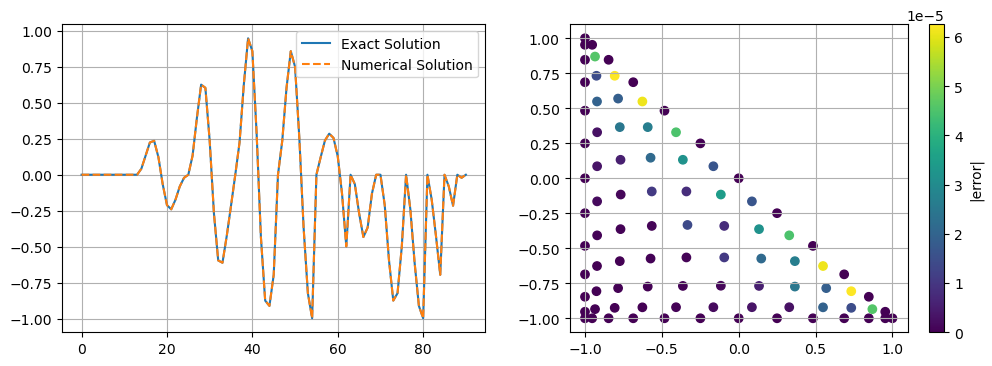

In [639]:
V_x = np.array([-1, 1, -1])
V_y = np.array([-1, -1, 1])
EtoV = np.array([[0, 1, 2]])
mesh_1 = create_toy_mesh(V_x, V_y, EtoV)

N = 12
discretization_element_1 = create_discretization_element(N = N, LocalReorder = np.arange((N+1)*(N+2)//2))
discretization_mesh_1 = create_discretization_mesh(mesh = mesh_1, discretization_element = discretization_element_1)

bvp_poisson_solver_1 = BVP_Poisson_solver(
    mesh = mesh_1,
    discretization_element = discretization_element_1,
    discretization_mesh = discretization_mesh_1,
    f_rhs = f_rhs,
    g_bc = u_exact
)

bvp_poisson_solver_1.solve()

u_N = bvp_poisson_solver_1.u_N
x_global, y_global = discretization_mesh_1.x_global, discretization_mesh_1.y_global

u_true = u_exact(x_global, y_global)
e = u_true - u_N

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(u_true, label="Exact Solution")
ax[0].plot(u_N, label="Numerical Solution", linestyle='--')
ax[0].legend();
ax[0].grid();

sc = ax[1].scatter(x_global, y_global, c=np.abs(e), cmap='viridis')
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

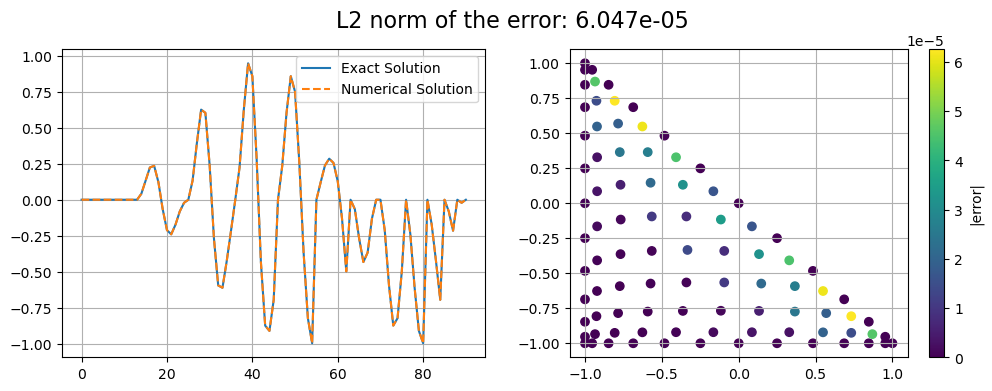

In [640]:
x_vertex_n = mesh_1.V_x[mesh_1.EtoV[0, :]]
y_vertex_n = mesh_1.V_y[mesh_1.EtoV[0, :]]

v1_n = np.array([x_vertex_n[0], y_vertex_n[0]])
v2_n = np.array([x_vertex_n[1], y_vertex_n[1]])
v3_n = np.array([x_vertex_n[2], y_vertex_n[2]])

Dx, Dy, M, _, _ = get_n_element_operators(
    discretization_element=discretization_element_1,
    v1_n=v1_n, v2_n=v2_n, v3_n=v3_n
)

x, y = discretization_mesh_1.x_global, discretization_mesh_1.y_global
u_true = u_exact(x, y)
f_rhs_values = f_rhs(x, y)

L_N = Dx.T @ M @ Dx + Dy.T @ M @ Dy
f_N = M @ f_rhs_values

# L_N = np.linalg.inv(M) @ Dx.T @ M @ Dx + Dy.T @ M @ Dy
# f_N = f_rhs_values

# the BC are not correctly presecrbied here with Allan LocalReorder
for idx in np.concatenate(discretization_element_1.fmask_list): 
    f_N = f_N - L_N[:, idx] * u_true[idx]
    L_N[idx, :] = 0
    L_N[:, idx] = 0
    L_N[idx, idx] = 1
    f_N[idx] = u_true[idx]

M_inv = np.linalg.inv(M)

L_N = M_inv @ L_N
f_N = M_inv @ f_N

u_N = np.linalg.solve(L_N, f_N)
err = u_true - u_N
L2_norm_error = np.sqrt(err @ M @ err)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(u_true, label="Exact Solution")
ax[0].plot(u_N, label="Numerical Solution", linestyle='--')
ax[0].legend();
ax[0].grid();

sc = ax[1].scatter(x_global, y_global, c=np.abs(err), cmap='viridis')
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

fig.suptitle(f"L2 norm of the error: {L2_norm_error:.3e}", fontsize=16);

### Square

In [641]:
V_x = np.array([-1, 1, 1, -1])
V_y = np.array([-1, -1, 1, 1])
EtoV = np.array([[1, 2, 4], [2, 3, 4]]) - 1
mesh_square = create_toy_mesh(V_x, V_y, EtoV)

N = 12
discretization_element_square = create_discretization_element(N = N)
discretization_mesh_square = create_discretization_mesh(mesh = mesh_square, discretization_element = discretization_element_square)

bvp_poisson_solver = BVP_Poisson_solver(
    mesh = mesh_square,
    discretization_element = discretization_element_square,
    discretization_mesh = discretization_mesh_square,
    f_rhs = f_rhs,
    g_bc = u_exact
)

bvp_poisson_solver.solve()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 54.32it/s]


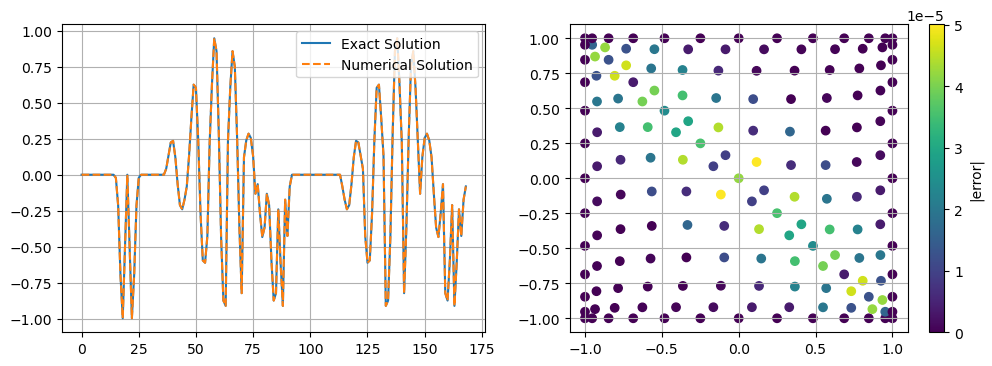

In [642]:
u_N = bvp_poisson_solver.u_N
x_global, y_global = discretization_mesh_toy.x_global, discretization_mesh_toy.y_global

u_true = u_exact(x_global, y_global)
e = u_N - u_true

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(u_true, label="Exact Solution")
ax[0].plot(u_N, label="Numerical Solution", linestyle='--')
ax[0].legend();
ax[0].grid();

sc = ax[1].scatter(x_global, y_global, c=np.abs(e), cmap='viridis')
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

### Circle

In [643]:
mesh2 = create_2d_circle(
    radius=1.0,
    origin=(0.0, 0.0),
    mesh_size=1
)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Done meshing 1D (Wall 0.000814167s, CPU 0.000264s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.006462s, CPU 0.004007s)
Info    : 72 nodes 143 elements


In [644]:
N = 10
discretization_element_2 = create_discretization_element(N = N)
discretization_mesh_2 = create_discretization_mesh(mesh = mesh2, discretization_element = discretization_element_2)

bvp_poisson_solver_2 = BVP_Poisson_solver(
    mesh = mesh2,
    discretization_element = discretization_element_2,
    discretization_mesh = discretization_mesh_2,
    f_rhs = f_rhs,
    g_bc = u_exact
)

bvp_poisson_solver_2.solve()

100%|██████████| 119/119 [00:01<00:00, 112.86it/s]


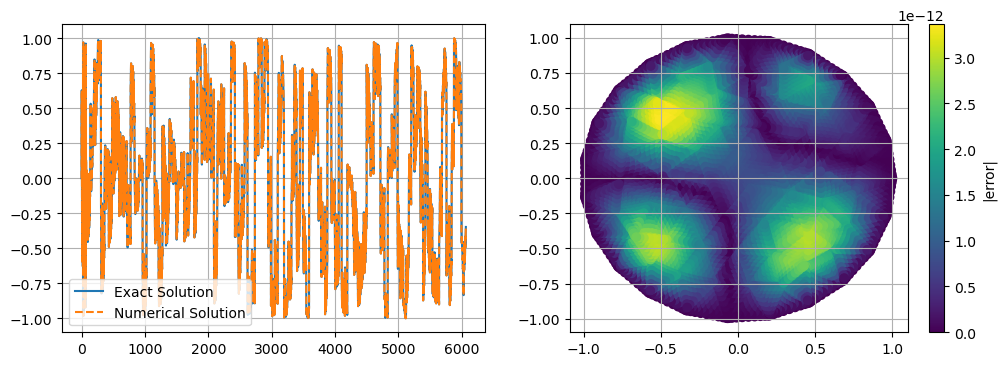

In [645]:
u_N = bvp_poisson_solver_2.u_N
x_global, y_global = discretization_mesh_2.x_global, discretization_mesh_2.y_global

u_true = u_exact(x_global, y_global)
e = u_N - u_true

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(u_true, label="Exact Solution")
ax[0].plot(u_N, label="Numerical Solution", linestyle='--')
ax[0].legend();
ax[0].grid();

sc = ax[1].scatter(x_global, y_global, c=np.abs(e), cmap='viridis')
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

In [664]:
def solve_bvp_convergence(N, mesh_solve_convergence):
    discretization_element = create_discretization_element(N = N)
    discretization_mesh = create_discretization_mesh(mesh = mesh_solve_convergence, discretization_element = discretization_element)

    bvp_poisson_solver = BVP_Poisson_solver(
        mesh = mesh_solve_convergence,
        discretization_element = discretization_element,
        discretization_mesh = discretization_mesh,
        f_rhs = f_rhs,
        g_bc = u_exact
    )

    bvp_poisson_solver.solve()

    u_N = bvp_poisson_solver.u_N
    x_global, y_global = discretization_mesh.x_global, discretization_mesh.y_global

    u_true = u_exact(x_global, y_global)
    err = u_true - u_N

    # Dx, Dy, M, _, _ = get_n_element_operators(
    #     discretization_element=discretization_element,
    #     v1_n=mesh2.V_x[mesh2.EtoV[:, 0]], 
    #     v2_n=mesh2.V_x[mesh2.EtoV[:, 1]], 
    #     v3_n=mesh2.V_x[mesh2.EtoV[:, 2]]
    # )

    # L2_norm_error = np.linalg.norm(err, ord = 2)
    L2_norm_error = np.linalg.norm(err, ord = np.inf)
    
    return L2_norm_error

In [665]:
N_array = np.arange(2, 10)
error_array = np.zeros(N_array.shape[0])
for N_idx, N_tmp in enumerate(tqdm(N_array)):
    # pass
    error_array[N_idx] = solve_bvp_convergence(N = N_tmp, mesh_solve_convergence=mesh2)

100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


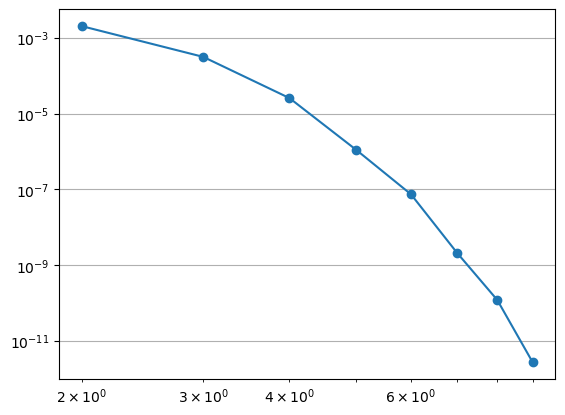

In [666]:
plt.loglog(N_array, error_array, marker='o')
plt.grid();

100%|██████████| 22/22 [00:02<00:00,  7.76it/s]


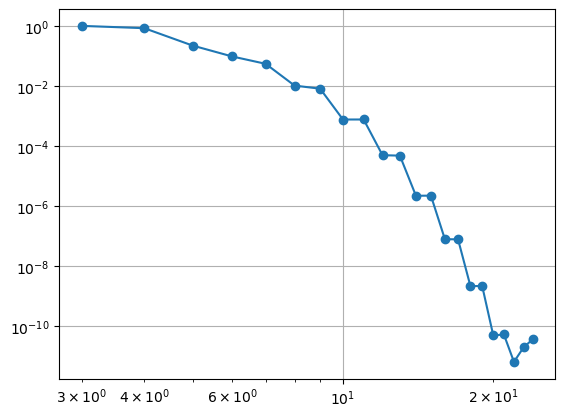

In [671]:
N_array = np.arange(3, 25)
error_array = np.zeros(N_array.shape[0])
for N_idx, N_tmp in enumerate(tqdm(N_array)):
    # pass
    error_array[N_idx] = solve_bvp_convergence(N = N_tmp, mesh_solve_convergence=mesh_square)

plt.loglog(N_array, error_array, marker='o')
plt.grid();

## Rotating Hill

In [634]:
# x_0, y_0 = -0.75, -0.25
# sigma = 0.1

# def get_hill_center(t, x_0 = x_0, y_0 = y_0):
#     x_t = x_0 * np.cos(np.pi*t/2) + y_0 * np.sin(np.pi*t/2)
#     y_t = -x_0 * np.sin(np.pi*t/2) + y_0 * np.cos(np.pi*t/2)
#     return x_t, y_t

# def u_exact_hill(x, y, t, sigma = sigma):
#     x_center_t, y_center_t = get_hill_center(t)
#     return np.exp(-((x - x_center_t)**2 + (y - y_center_t)**2)/(2*sigma**2))

# def f_rhs_hill(x, y, t, sigma = sigma):
#     return np.zeros(x.shape)

# # def u_exact_hill_dt(x, y, t, sigma=sigma):
# #     """
# #     Time derivative ∂_t u_exact_hill(x,y,t).
# #     u(x,y,t) = exp(-((x-xc)^2 + (y-yc)^2)/(2*sigma^2)),
# #     center (xc,yc) rotates with angular speed ω = π/2:
# #       xc' = ω * yc,   yc' = -ω * xc
# #     ∂_t u = u * [ (x-xc) xc' + (y-yc) yc' ] / sigma^2
# #     """
# #     xc, yc = get_hill_center(t)
# #     omega = np.pi / 2.0
# #     xc_t = omega * yc
# #     yc_t = -omega * xc
# #     u = u_exact_hill(x, y, t, sigma=sigma)
# #     return u * ((x - xc) * xc_t + (y - yc) * yc_t) / (sigma**2)


# def u_exact_hill_dt(x, y, t, sigma=sigma):
#     omega = 2 * np.pi
#     xc, yc = get_hill_center(t)
#     xc_t = omega * yc
#     yc_t = -omega * xc
#     u = u_exact_hill(x, y, t, sigma=sigma)
#     return u * ((x - xc) * xc_t + (y - yc) * yc_t) / (sigma**2)

# def advection_velocity_field(x, y):
#     return (2 * np.pi * y, -2 * np.pi * x)

# t_array = np.linspace(0, 0.1, 100)
# x_center_t, y_center_t = get_hill_center(t_array)

x_0, y_0 = -0.75, -0.25
sigma = 0.1

def get_hill_center(
    t: float, *, x_0: npt.NDArray, y_0: npt.NDArray
) -> tuple[npt.NDArray, npt.NDArray]:
    omega = 2 * np.pi
    x_t = x_0 * np.cos(omega * t) + y_0 * np.sin(omega * t)
    y_t = -x_0 * np.sin(omega * t) + y_0 * np.cos(omega * t)
    return x_t, y_t


def u_exact_hill(x, y, t, sigma=sigma):
    x_center_t, y_center_t = get_hill_center(t, x_0=x_0, y_0=y_0)
    return np.exp(-((x - x_center_t) ** 2 + (y - y_center_t) ** 2) / (2 * sigma**2))


def u_exact_hill_dt(x, y, t, x_0=x_0, y_0=y_0, sigma=sigma):
    omega = 2 * np.pi
    xc, yc = get_hill_center(t, x_0=x_0, y_0=y_0)
    xc_t = omega * yc
    yc_t = -omega * xc
    u = u_exact_hill(x, y, t, sigma=sigma)
    return u * ((x - xc) * xc_t + (y - yc) * yc_t) / (sigma**2)


def f_rhs_hill(x: npt.NDArray, y: npt.NDArray, t: float) -> npt.NDArray:
    return np.zeros_like(x)


def advection_velocity_field(x: npt.NDArray, y: npt.NDArray) -> tuple[npt.NDArray, npt.NDArray]:
    return (2 * np.pi * y, -2 * np.pi * x)

### One element

In [635]:
V_x = np.array([-1, 1, -1])
V_y = np.array([-1, 1, 1])
EtoV = np.array([[0, 1, 2]])
mesh_hill_1 = create_toy_mesh(V_x, V_y, EtoV)

N = 20
discretization_element_hill_1 = create_discretization_element(N = N, LocalReorder = np.arange((N+1)*(N+2)//2))
discretization_mesh_hill_1 = create_discretization_mesh(mesh = mesh_hill_1, discretization_element = discretization_element_hill_1)

r, s = discretization_element_hill_1.r, discretization_element_hill_1.s
x_global, y_global = discretization_mesh_hill_1.x_global, discretization_mesh_hill_1.y_global
print(f"{x_global.shape = }")

x_global.shape = (231,)


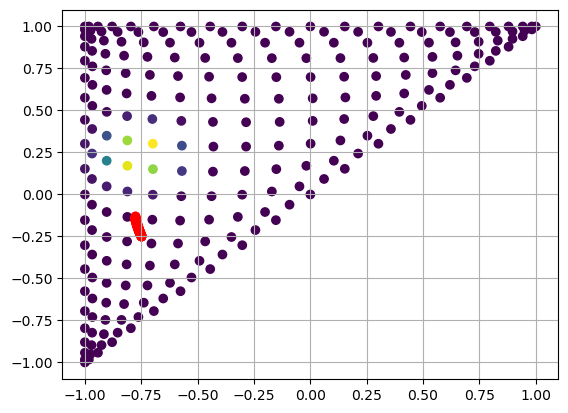

In [636]:
u_true_t = u_exact_hill(x_global, y_global, t=t_array[:, None])
u_0 = u_exact_hill(x_global, y_global, t=0)

plt.scatter(x_global, y_global, c=u_true_t[-1, :], cmap='viridis')
# plt.scatter(x_global, y_global, c=u_0, cmap='viridis')
plt.scatter(x_center_t, y_center_t, color='red')
plt.grid();

In [ ]:
# based on section 5.2 FEM book, equation 5.15
class IVP_hill_solver():
    """
    solve du_dt = - (a_x * du_dx + a_y * du_dy)
    discretization SEM: M du_dt = - L u + f
    """

    def __init__(self, mesh: Mesh, discretization_element: DiscretizationElement, discretization_mesh: DiscretizationMesh,
                g_bc, g_bc_dt, f_rhs, advection_velocity_field):
        self.mesh = mesh
        self.discretization_element = discretization_element
        self.discretization_mesh = discretization_mesh
        self.advection_velocity_field = advection_velocity_field
        self.g_bc = g_bc  # function (x, y, t)
        self.g_bc_dt = g_bc_dt
        self.f_rhs = f_rhs  # function (x, y, t)
        self.L_N_list = list()
        self.f_N_list = list()
        self.M_global_list = list()
        # self.Chol_M_global = None
        # self.Chol_lower = None
        self.t_list = list()

        # Assemble constant matrices immediately (since velocity field is stationary)

    def construct_L_n_element_t(self, Dx, Dy, M, x_n, y_n, t):
        # this element is stationary

        # x_center_t, y_center_t = get_hill_center(t)
        # return 2*np.pi * (y_center_t * Dx - x_center_t * Dy) @ M
        # return 2*np.pi * M @ (y_center_t * Dx - x_center_t * Dy)

        ax, ay = self.advection_velocity_field(x_n, y_n)
        return M @ (np.diag(ax) @ Dx + np.diag(ay) @ Dy)

    def construct_global_assembly_t(self, t):
    # def construct_global_assembly(self):
        # we assume stationary velocity field; construct L_N, f_N

        L_N_t = np.zeros((self.discretization_mesh.gidx, self.discretization_mesh.gidx))
        f_N_t = np.zeros(self.discretization_mesh.gidx)
        M_global_t = np.zeros((self.discretization_mesh.gidx, self.discretization_mesh.gidx))

        Mp = self.discretization_element.Mp
        C = self.discretization_mesh.C
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        # Allan FEM book: Algo 15, 16
        for n_element in tqdm(range(self.mesh.num_elements)):

            x_vertex_n = self.mesh.V_x[self.mesh.EtoV[n_element, :]]
            y_vertex_n = self.mesh.V_y[self.mesh.EtoV[n_element, :]]

            v1_n = np.array([x_vertex_n[0], y_vertex_n[0]])
            v2_n = np.array([x_vertex_n[1], y_vertex_n[1]])
            v3_n = np.array([x_vertex_n[2], y_vertex_n[2]])

            Dx, Dy, M, x_n, y_n = get_n_element_operators(
                discretization_element=self.discretization_element,
                v1_n=v1_n, v2_n=v2_n, v3_n=v3_n
            )

            L_n_element_t = self.construct_L_n_element_t(t=None, Dx=Dx, Dy=Dy, M=M, x_n=x_n, y_n=y_n)

            for j in range(Mp):
                for i in range(Mp):
                    # exploit symmetry, not working
                    # if C[n_element, j] >= C[n_element, i]:
                    L_N_t[C[n_element, i], C[n_element, j]] += L_n_element_t[i, j]

            for j in range(Mp):
                jj = C[n_element, j]
                x_j = x_global[jj]
                y_j = y_global[jj]
                for i in range(Mp):
                    ii = C[n_element, i]
                    f_N_t[ii] += M[i, j] * self.f_rhs(x_j, y_j, t) # global assembly b_i(t) FEM
                    # f_N_t[ii] = self.f_rhs(x_j, y_j, t)

            # assembling of global Mass matrix
            # if self.M_global is None:
            for j in range(Mp):
                for i in range(Mp):
                    # exploit symmetry, not working
                    # if C[n_element, j] >= C[n_element, i]:
                    M_global_t[C[n_element, i], C[n_element, j]] += M[i, j]

        self.t_list.append(t)
        self.L_N_list.append(L_N_t)
        self.f_N_list.append(f_N_t)
        self.M_global_list.append(M_global_t)
        # if self.M_global is None:
        #     self.M_global = M_global_t

    def prescribe_boundary_conditions_t(self, t):

        BC_nodes = self.discretization_mesh.BC_nodes
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        L_N_t = self.L_N_list[-1].copy()
        f_N_t = self.f_N_list[-1].copy()
        M_global_t = self.M_global_list[-1].copy()

        # if self.Chol_lower is None:
        #     for i in BC_nodes:
        #         M_global[i, :] = 0.0
        #         M_global[:, i] = 0.0
        #         M_global[i, i] = 1.0
        #     self.M_global = M_global

        # Allan FEM book: Algo 17
        for i in BC_nodes:
            # correct: in FEM book the f function are KNOWN boundary conditions -> so u_exact
            u_i_t = self.g_bc(x_global[i], y_global[i], t = t)   # Dirichlet value
            u_i_t_dt = self.g_bc_dt(x_global[i], y_global[i], t = t)
            # # update ALL equations
            f_N_t = f_N_t - L_N_t[:, i] * u_i_t - M_global_t[:, i] * u_i_t_dt
            L_N_t[i, :] = 0.0
            L_N_t[:, i] = 0.0
            # L_N_t[i, i] = 1.0

            M_global_t[i, :] = 0.0
            M_global_t[:, i] = 0.0
            M_global_t[i, i] = 1.0

        for i in BC_nodes:
            # f_N_t[i] = self.g_bc(x_global[i], y_global[i], t=t)
            f_N_t[i] = self.g_bc_dt(x_global[i], y_global[i], t = t)

        self.L_N_list[-1] = L_N_t
        self.f_N_list[-1] = f_N_t
        self.M_global_list[-1] = M_global_t


    # def factorize_M_global(self):
    #     if self.Chol_lower is None:
    #         print("Factorizing M_global")
    #         Chol_M_global, Chol_lower = sp.linalg.cho_factor(self.M_global)
    #         self.Chol_M_global = Chol_M_global
    #         self.Chol_lower = Chol_lower


    def get_rhs_IVP(self, t, u):
        # put list here, better callback function 
        self.construct_global_assembly_t(t=t)
        self.prescribe_boundary_conditions_t(t=t)
        # self.factorize_M_global()

        # BC_nodes = self.discretization_mesh.BC_nodes
        # x_global = self.discretization_mesh.x_global
        # y_global = self.discretization_mesh.y_global

        M_global = self.M_global_list[-1]
        L_N_t = self.L_N_list[-1]
        f_N_t = self.f_N_list[-1]

        du_dt_M = - L_N_t @ u + f_N_t
        # du_dt = sp.linalg.cho_solve((self.Chol_M_global, self.Chol_lower), du_dt_M)
        du_dt = np.linalg.solve(M_global, du_dt_M)
        # if self.cb not None:
        #     self.cb(t, u, du_dt)
        return du_dt
    

In [623]:
ivp_hill_solver_1 = IVP_hill_solver(
    mesh = mesh_hill_1,
    discretization_element = discretization_element_hill_1,
    discretization_mesh = discretization_mesh_hill_1,
    f_rhs = f_rhs_hill,
    g_bc = u_exact_hill,
    g_bc_dt = u_exact_hill_dt,
    advection_velocity_field = advection_velocity_field
)

dudt = ivp_hill_solver_1.get_rhs_IVP(t=0, u=u_0)
# print(dudt.shape, u_0.shape)

100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


In [624]:
# # ivp_hill_solver_1.construct_global_assembly_t(t=0)
# # ivp_hill_solver_1.construct_free_bc_operators()

# M_global_free = ivp_hill_solver_1.M_global_free
# L_N_free = ivp_hill_solver_1.L_N_free

# M_global_bc = ivp_hill_solver_1.M_global_bc
# L_N_bc = ivp_hill_solver_1.L_N_bc

In [625]:
t0, tf = 0.0, 0.1
u_0 = u_exact_hill(x_global, y_global, t=0)
result_scipy = solve_ivp(
    ivp_hill_solver_1.get_rhs_IVP,
    [t0, tf],
    y0 = u_0,
    method = "RK45",
    # max_step = max_step,
    # rtol=rtol,
    # atol=atol
)

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


In [626]:
u_N_t = result_scipy.y
print(u_N_t.shape)

t_ivp_solver = result_scipy.t

u_true_ivp_solver = u_exact_hill(x_global, y_global, t=t_ivp_solver[:, None])
u_true_ivp_solver = u_true_ivp_solver.T

err = np.abs(u_true_ivp_solver - u_N_t)
norm_err_t = np.linalg.norm(err, ord = np.inf, axis=0)
norm_err_xy = np.linalg.norm(err, ord = np.inf, axis=1)
print(f"{err.shape = }")

(231, 29)
err.shape = (231, 29)


In [627]:
BC_nodes = discretization_mesh_hill_1.BC_nodes

g_bc_dt_values = ivp_hill_solver_1.g_bc_dt(x_global[BC_nodes], y_global[BC_nodes], t=20)

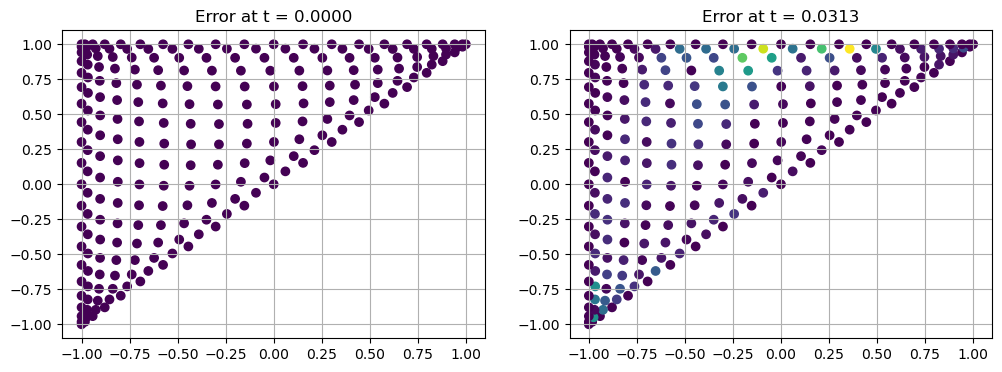

In [628]:
t_test_1, t_test_2 = 0, 10

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x_global, y_global, c = err[:, t_test_1])
ax[0].set_title(f"Error at t = {t_ivp_solver[t_test_1]:.4f}")
ax[0].grid();
ax[1].scatter(x_global, y_global, c = err[:, t_test_2])
ax[1].set_title(f"Error at t = {t_ivp_solver[t_test_2]:.4f}")
ax[1].grid();

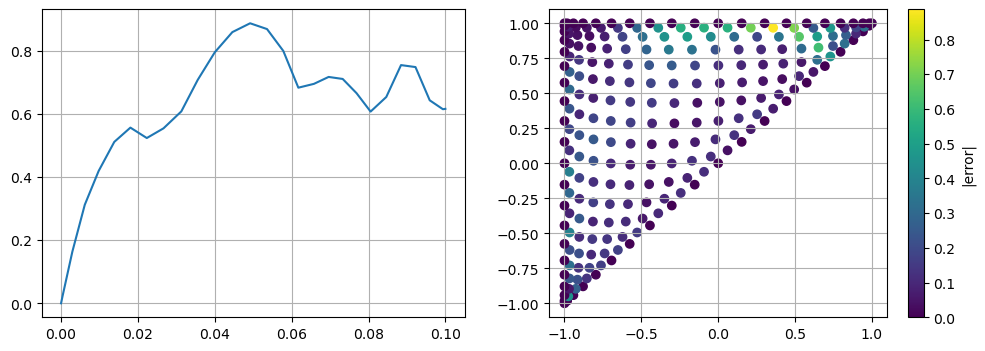

In [629]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_ivp_solver, norm_err_t)
ax[0].grid();
sc = ax[1].scatter(x_global, y_global, c = norm_err_xy)
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

### Second try

In [ ]:
# based on section 5.2 FEM book, equation 5.15
class IVP_hill_solver():
    """
    solve du_dt = - (a_x * du_dx + a_y * du_dy)
    discretization SEM: M du_dt = - L u + f
    """

    def __init__(self, mesh: Mesh, discretization_element: DiscretizationElement, discretization_mesh: DiscretizationMesh,
                g_bc, g_bc_dt, f_rhs, advection_velocity_field):
        self.mesh = mesh
        self.discretization_element = discretization_element
        self.discretization_mesh = discretization_mesh
        self.advection_velocity_field = advection_velocity_field
        self.g_bc = g_bc  # function (x, y, t)
        self.g_bc_dt = g_bc_dt
        self.f_rhs = f_rhs  # function (x, y, t)
        self.L_N_list = list()
        self.f_N_list = list()
        self.M_global = None
        self.M_global_bc = None
        self.M_global_free = None
        self.L_N_bc = None
        self.L_N_free = None
        # self.Chol_M_global = None
        # self.Chol_lower = None
        self.t_list = list()

        # Assemble constant matrices immediately (since velocity field is stationary)

    def construct_L_n_element_t(self, Dx, Dy, M, x_n, y_n, t):
        # this element is stationary

        ax, ay = self.advection_velocity_field(x_n, y_n)
        return M @ (np.diag(ax) @ Dx + np.diag(ay) @ Dy)

    def construct_global_assembly_t(self, t):
    # def construct_global_assembly(self):
        # we assume stationary velocity field; construct L_N, f_N

        L_N_t = np.zeros((self.discretization_mesh.gidx, self.discretization_mesh.gidx))
        f_N_t = np.zeros(self.discretization_mesh.gidx)
        if self.M_global is None:
            M_global_t = np.zeros((self.discretization_mesh.gidx, self.discretization_mesh.gidx))

        Mp = self.discretization_element.Mp
        C = self.discretization_mesh.C
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        # Allan FEM book: Algo 15, 16
        for n_element in tqdm(range(self.mesh.num_elements)):

            x_vertex_n = self.mesh.V_x[self.mesh.EtoV[n_element, :]]
            y_vertex_n = self.mesh.V_y[self.mesh.EtoV[n_element, :]]

            v1_n = np.array([x_vertex_n[0], y_vertex_n[0]])
            v2_n = np.array([x_vertex_n[1], y_vertex_n[1]])
            v3_n = np.array([x_vertex_n[2], y_vertex_n[2]])

            Dx, Dy, M, x_n, y_n = get_n_element_operators(
                discretization_element=self.discretization_element,
                v1_n=v1_n, v2_n=v2_n, v3_n=v3_n
            )

            L_n_element_t = self.construct_L_n_element_t(t=None, Dx=Dx, Dy=Dy, M=M, x_n=x_n, y_n=y_n)

            for j in range(Mp):
                for i in range(Mp):
                    # exploit symmetry, not working
                    # if C[n_element, j] >= C[n_element, i]:
                    L_N_t[C[n_element, i], C[n_element, j]] += L_n_element_t[i, j]

            for j in range(Mp):
                jj = C[n_element, j]
                x_j = x_global[jj]
                y_j = y_global[jj]
                for i in range(Mp):
                    ii = C[n_element, i]
                    # f_N_t[ii] += M[i, j] * self.f_rhs(x_j, y_j, t)
                    f_N_t[ii] = self.f_rhs(x_j, y_j, t)

            # assembling of global Mass matrix
            if self.M_global is None:
                for j in range(Mp):
                    for i in range(Mp):
                        # exploit symmetry, not working
                        # if C[n_element, j] >= C[n_element, i]:
                        M_global_t[C[n_element, i], C[n_element, j]] += M[i, j]

        self.t_list.append(t)
        self.L_N_list.append(L_N_t)
        self.f_N_list.append(f_N_t)
        if self.M_global is None:
            self.M_global = M_global_t


    def construct_free_bc_operators(self):
        BC_nodes = self.discretization_mesh.BC_nodes

        M_global = self.M_global.copy()
        L_N_global = self.L_N_list[-1].copy()

        M_global_bc = np.zeros((self.discretization_mesh.gidx, self.discretization_mesh.gidx))
        L_N_bc = np.zeros((self.discretization_mesh.gidx, self.discretization_mesh.gidx))

        M_global_free = M_global.copy()
        L_N_free = L_N_global.copy()

        for i in BC_nodes:
            M_global_bc[:, i] = M_global[:, i]
            M_global_bc[i, i] = 0

            L_N_bc[:, i] = L_N_global[:, i]
            L_N_bc[i, i] = 0

        for i in BC_nodes:
            M_global_free[:, i] = 0.0
            M_global_free[i, :] = 0.0
            M_global_free[i, i] = 1.0

            L_N_free[:, i] = 0.0
            L_N_free[i, :] = 0.0

        self.M_global_bc = M_global_bc
        self.M_global_free = M_global_free
        self.L_N_bc = L_N_bc
        self.L_N_free = L_N_free


    def prescribe_boundary_conditions_t(self, t):

        BC_nodes = self.discretization_mesh.BC_nodes
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        L_N_t = self.L_N_list[-1].copy()
        f_N_t = self.f_N_list[-1].copy()
        M_global = self.M_global.copy()

        # if self.Chol_lower is None:
        #     for i in BC_nodes:
        #         M_global[i, :] = 0.0
        #         M_global[:, i] = 0.0
        #         M_global[i, i] = 1.0
        #     self.M_global = M_global

            
        # Allan FEM book: Algo 17
        for i in BC_nodes:
            # correct: in FEM book the f function are KNOWN boundary conditions -> so u_exact
            u_i_t = self.g_bc(x_global[i], y_global[i], t = t)   # Dirichlet value
            u_i_t_dt = self.g_bc_dt(x_global[i], y_global[i], t = t)
            # # update ALL equations
            f_N_t = f_N_t - L_N_t[:, i] * u_i_t - M_global[:, i] * u_i_t_dt
            L_N_t[i, :] = 0.0
            L_N_t[:, i] = 0.0
            # L_N_t[i, i] = 1.0

        for i in BC_nodes:
            # f_N_t[i] = self.g_bc(x_global[i], y_global[i], t=t)
            f_N_t[i] = self.g_bc_dt(x_global[i], y_global[i], t = t)

        self.L_N_list[-1] = L_N_t
        self.f_N_list[-1] = f_N_t


    
    # def factorize_M_global(self):
    #     if self.Chol_lower is None:
    #         print("Factorizing M_global")
    #         Chol_M_global, Chol_lower = sp.linalg.cho_factor(self.M_global)
    #         self.Chol_M_global = Chol_M_global
    #         self.Chol_lower = Chol_lower

    # def solve(self):
    #     self.construct_global_assembly()
    #     self.prescribe_boundary_conditions()
    #     self.u_N = np.linalg.solve(self.L_N, self.f_N)

    # def get_rhs_IVP(self, t, u):
    #     # put list here, better callback function 
    #     self.construct_global_assembly_t(t=t)
    #     self.prescribe_boundary_conditions_t(t=t)
    #     # self.factorize_M_global()

    #     BC_nodes = self.discretization_mesh.BC_nodes
    #     x_global = self.discretization_mesh.x_global
    #     y_global = self.discretization_mesh.y_global

    #     # M_global_free = self.M_global_free.copy()

    #     L_N_t = self.L_N_list[-1]
    #     f_N_t = self.f_N_list[-1]
    #     # du_dt_M = - L_N_t @ u + self.M_global @ f_N_t
    #     # du_dt_M = 
    #     f_rhs = self.f_rhs(x_global, y_global, t)
    #     du_dt_M = f_N_t + self.M_global @ f_rhs


    #     # du_dt = sp.linalg.cho_solve((self.Chol_M_global, self.Chol_lower), du_dt_M)
    #     du_dt = np.linalg.solve(self.M_global, du_dt_M)
    #     # if self.cb not None:
    #     #     self.cb(t, u, du_dt)
    #     return du_dt
    
    def get_rhs_IVP(self, t, u):
        # put list here, better callback function 
        self.construct_global_assembly_t(t=t)
        self.construct_free_bc_operators()
        # self.factorize_M_global()

        BC_nodes = self.discretization_mesh.BC_nodes
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        M_global_free = self.M_global_free.copy()
        M_global_bc = self.M_global_bc.copy()
        L_N_free = self.L_N_free.copy()
        L_N_bc = self.L_N_bc.copy()

        # M_global_free = self.M_global_free.copy()

        f_rhs = self.f_rhs(x_global, y_global, t)
        g_bc_N = self.g_bc(x_global, y_global, t = t)   # Dirichlet value
        g_bc_dt_N = self.g_bc_dt(x_global, y_global, t = t)

        # print(f"{f_rhs.shape = }, {g_bc_N.shape = }, {g_bc_dt_N.shape = }")
        # print(f"{u.shape = }")
        # print(f"{L_N_free.shape = }, {L_N_bc.shape = }")
        # print(f"{M_global_free.shape = }, {M_global_bc.shape = }")

        du_dt_M = - L_N_free @ u \
                + M_global_free @ f_rhs \
                - L_N_bc @ g_bc_N \
                - M_global_bc @ g_bc_dt_N
        
        du_dt_M[BC_nodes] = g_bc_dt_N[BC_nodes]
 
        # u[BC_nodes] = u_i_t[BC_nodes]

        # L_N_t = self.L_N_list[-1]
        # f_N_t = self.f_N_list[-1]
        # # du_dt_M = - L_N_t @ u + self.M_global @ f_N_t
        # # du_dt_M = 
        # du_dt_M = f_N_t + self.M_global @ f_rhs

        # du_dt = sp.linalg.cho_solve((self.Chol_M_global, self.Chol_lower), du_dt_M)
        du_dt = np.linalg.solve(self.M_global_free, du_dt_M)
        # if self.cb not None:
        #     self.cb(t, u, du_dt)
        return du_dt    

### Circle

## Appendix